In [1]:
%matplotlib widget

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
psd_kernels = tfp.math.psd_kernels

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import jacques
# from jacques import kcqe
from jacovid import util
from jacovid import kcqe

In [2]:
data = util.load_data()
data

,location,date,inc_hosp,population,rate
1029,AK,2020-10-01,3.0,731545,0.410091
1030,AK,2020-10-02,7.0,731545,0.956879
1031,AK,2020-10-03,5.0,731545,0.683485
1032,AK,2020-10-04,5.0,731545,0.683485
1033,AK,2020-10-05,1.0,731545,0.136697
...,...,...,...,...,...
39496,WY,2021-06-27,10.0,578759,1.727835
39497,WY,2021-06-28,9.0,578759,1.555051
39498,WY,2021-06-29,7.0,578759,1.209484
39499,WY,2021-06-30,8.0,578759,1.382268


In [3]:
data = pd.read_csv('demo_data.csv')[['location', 'date', 'inc_hosp', 'population', 'rate']]
data

,location,date,inc_hosp,population,rate
0,AK,2020-10-01,3.0,731545,0.410091
1,AK,2020-10-02,7.0,731545,0.956879
2,AK,2020-10-03,5.0,731545,0.683485
3,AK,2020-10-04,5.0,731545,0.683485
4,AK,2020-10-05,1.0,731545,0.136697
...,...,...,...,...,...
13969,WY,2021-06-27,10.0,578759,1.727835
13970,WY,2021-06-28,9.0,578759,1.555051
13971,WY,2021-06-29,7.0,578759,1.209484
13972,WY,2021-06-30,8.0,578759,1.382268


In [4]:
kcqe_rm = kcqe.kcqe_rollmean(x_kernel = 'gaussian_diag',
                             lags = [7, 14, 21],
                             h = 14,
                             tau = tf.constant(np.array([0.1, 0.5, 0.9])))
kcqe_rm.fit(data, num_epochs = 10)
q_hat = kcqe_rm.predict()

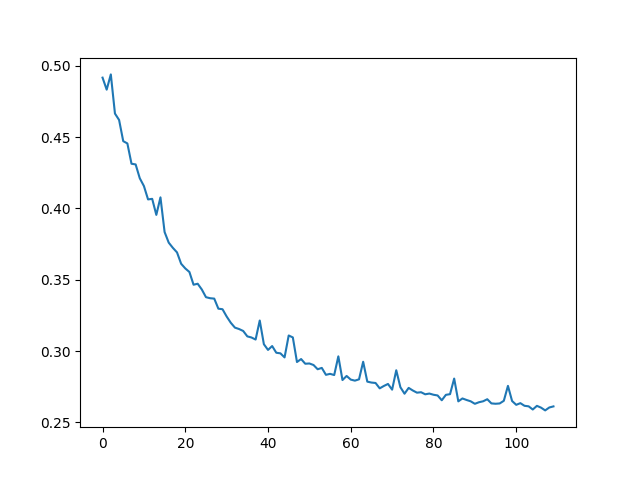

In [25]:
plt.close()
plt.plot(kcqe_rm.kcqe_obj.loss_trace)
plt.show()

/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_85222/3137045033.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


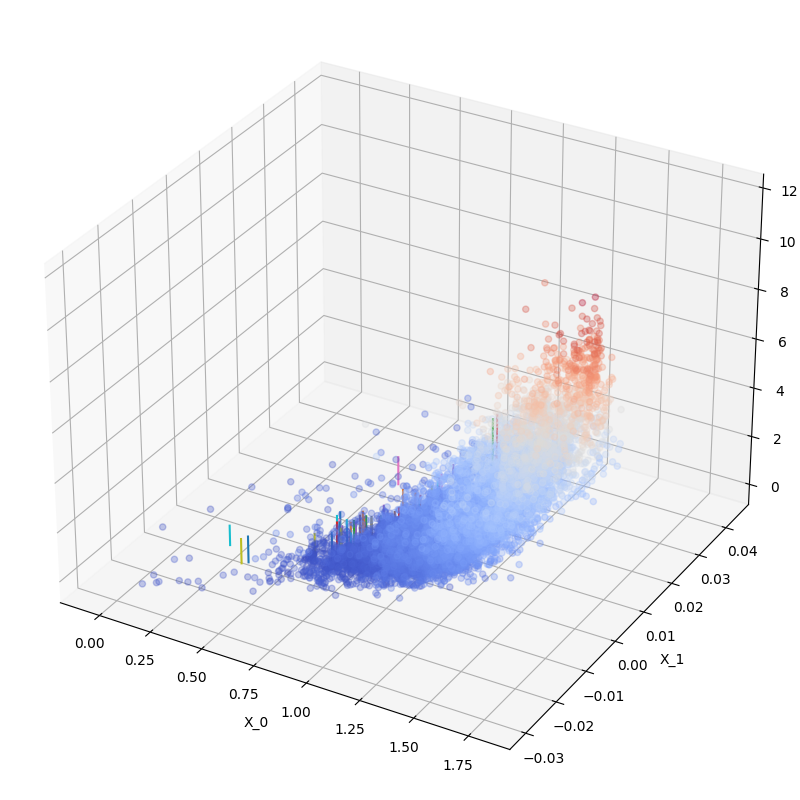

In [38]:
fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(data.dropna().fourth_rt_rate_taylor_0,
           data.dropna().fourth_rt_rate_taylor_1,
           data.dropna().rate_h_14,
           c=data.dropna().rate_h_14,
           cmap = cm.coolwarm,
           alpha = 0.3)


for loc_ind in range(x_test.shape[1]):
    loc_x_test = x_test[0, loc_ind, :].numpy()
    plt.plot(
        np.full(2, loc_x_test[0]),
        np.full(2, loc_x_test[1]),
        q_hat.numpy()[(0, loc_ind, np.array([0, 2]))]
    )
# ax.lines(np.full(2, loc_x_test[0]),
#          np.full(2, loc_x_test[1]),
#          q_hat.numpy()[(0, 0, np.array([0, 2]))])

# x0_grid = x_test[..., 0].numpy().reshape((grid_size, grid_size))
# x1_grid = x_test[..., 1].numpy().reshape((grid_size, grid_size))
# q_grid_q10 = q_hat[..., 0].numpy().reshape((grid_size, grid_size))
# q_grid_median = q_hat[..., 1].numpy().reshape((grid_size, grid_size))
# q_grid_q90 = q_hat[..., 2].numpy().reshape((grid_size, grid_size))

# ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
# ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
# ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()

In [9]:
q_hat

<tf.Tensor: shape=(51, 1, 3), dtype=float64, numpy=
array([[[0.12872945, 0.35452722, 0.86318061]],

       [[0.53741881, 1.03050702, 1.48419912]],

       [[0.80442293, 1.33896274, 4.40493732]],

       [[0.70262358, 0.90518322, 1.3150723 ]],

       [[0.34284751, 0.45104312, 0.71032624]],

       [[0.71321558, 1.11252634, 1.73859908]],

       [[0.11651941, 0.22850301, 0.35014044]],

       [[0.28967887, 0.65705594, 1.22743205]],

       [[0.        , 0.10743465, 0.25621873]],

       [[1.10726908, 1.62285247, 2.70990933]],

       [[0.65854222, 0.91868918, 1.4642675 ]],

       [[0.1058267 , 0.33722609, 0.6868628 ]],

       [[0.24947704, 0.45908702, 0.95699635]],

       [[0.42032138, 0.68270984, 1.10701769]],

       [[0.29039376, 0.40347193, 0.96569574]],

       [[0.39412223, 0.63882137, 1.44868087]],

       [[0.44688274, 0.68557805, 1.05186887]],

       [[1.71630591, 2.29364758, 2.912718  ]],

       [[0.82999495, 1.05930456, 1.58093901]],

       [[0.12418668, 0.17375917, 0.2

In [17]:
state_info = util.load_locations()

quantiles = [0.1, 0.5, 0.9]

predictions = pd.concat(
    [
        pd.DataFrame({
            'location': data.location.unique(),
            'quantile': [q_level] * len(data.location.unique()),
            'value': q_hat[:, 0, i]
        }) \
            for i, q_level in enumerate(quantiles)
    ],
    axis = 0)

# merge in population column
predictions = predictions.merge(state_info[['abbreviation','location','population']],
                                left_on="location",
                                right_on="abbreviation",
                                how = "left")

# clean up detritus from merging
predictions = predictions[['abbreviation', 'location_y', 'quantile', 'value', 'population']]
predictions.columns = ['abbreviation', 'location', 'quantile', 'value', 'population']

# update predictions to original units rather than rates per 100k population
predictions['pop100k'] = predictions.population / 100000
predictions['value'] = predictions.value * predictions.pop100k

predictions

,abbreviation,location,quantile,value,population,pop100k
0,AK,02,0.1,0.941714,731545,7.31545
1,AL,01,0.1,26.350638,4903185,49.03185
2,AR,05,0.1,24.275907,3017804,30.17804
3,AZ,04,0.1,51.141982,7278717,72.78717
4,CA,06,0.1,135.466673,39512223,395.12223
...,...,...,...,...,...,...
148,VT,50,0.9,5.717756,623989,6.23989
149,WA,53,0.9,89.389664,7614893,76.14893
150,WI,55,0.9,55.346465,5822434,58.22434
151,WV,54,0.9,33.763505,1792147,17.92147


In [19]:
data.date = pd.to_datetime(data.date)

<ipython-input-20-d8dd7b631bd4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_pred['date'] = last_obs_date + pd.Timedelta(14, 'days')
<ipython-input-20-d8dd7b631bd4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_pred['date'] = last_obs_date + pd.Timedelta(14, 'days')
<ipython-input-20-d8dd7b631bd4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

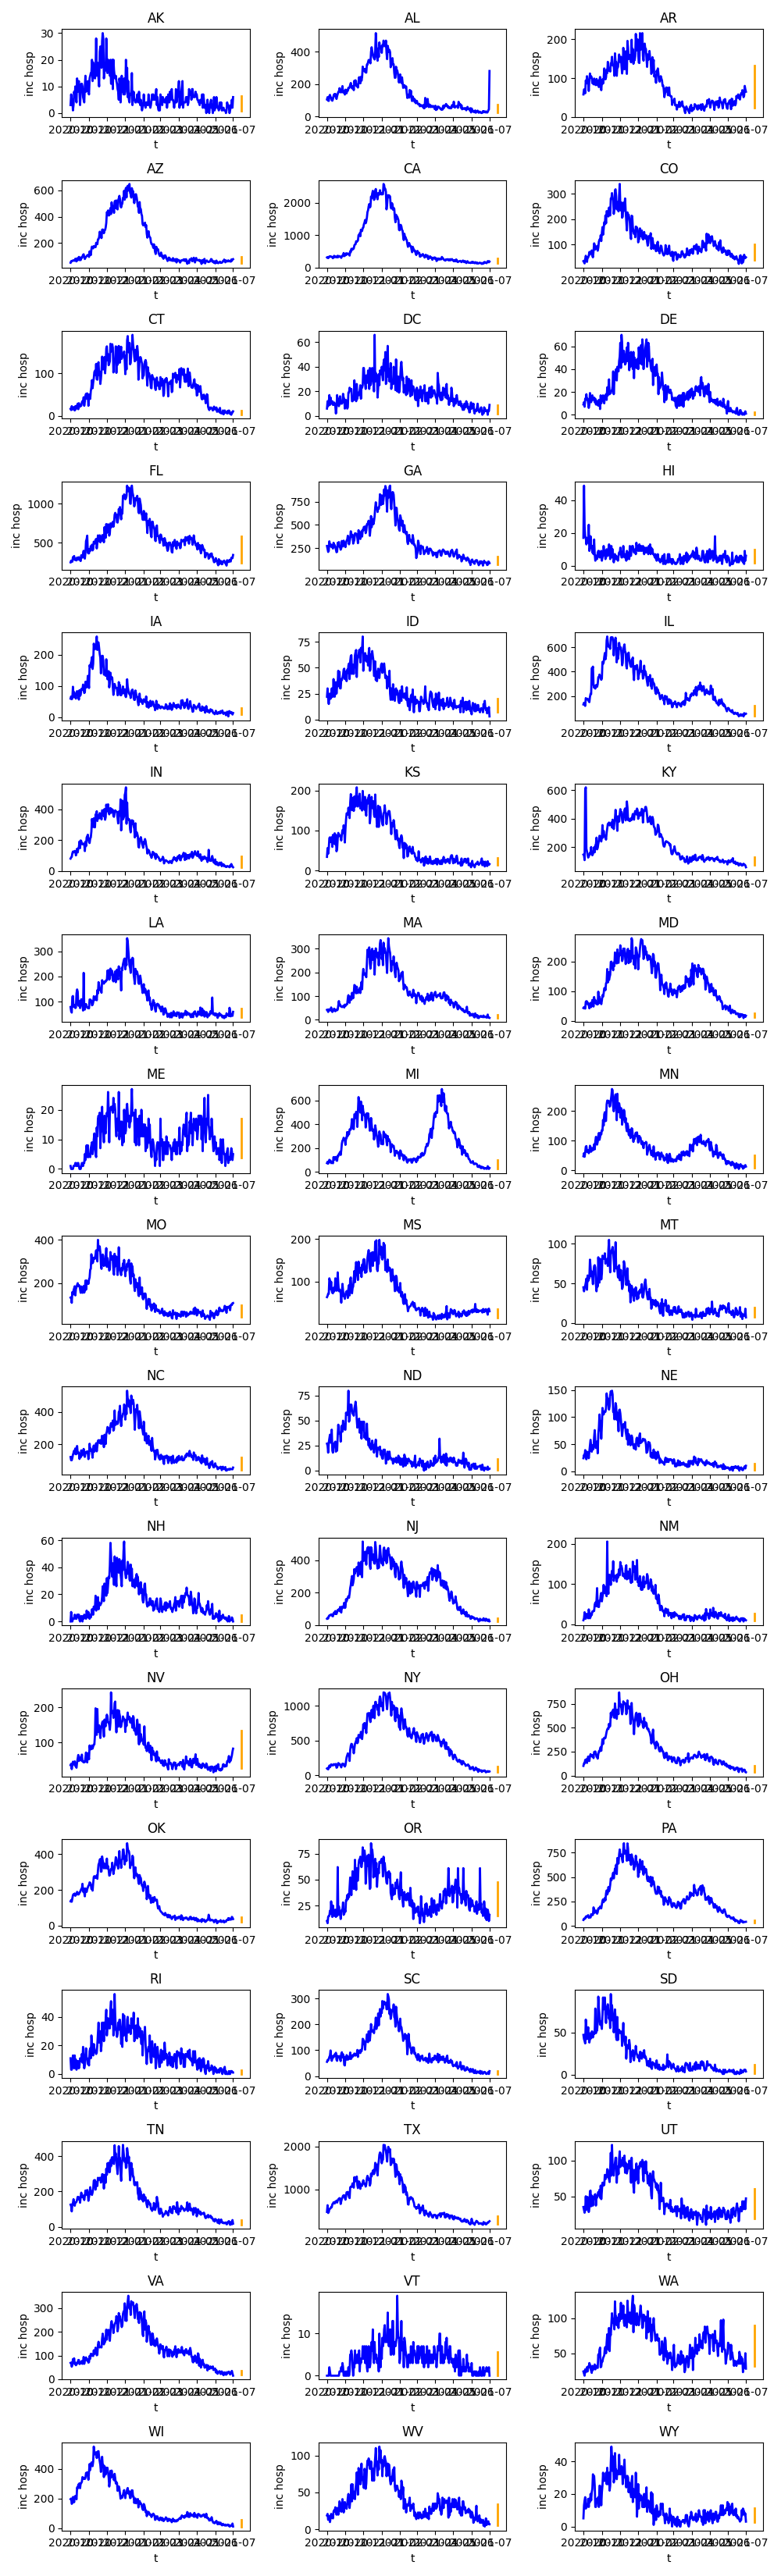

In [20]:
fig, ax = plt.subplots(17, 3, figsize=(10, 33))

for i, loc in enumerate(data.location.unique()):
    loc_data = data[data.location == loc]
    last_obs_date = np.max(loc_data.date)
    loc_pred = predictions[predictions.abbreviation == loc]
    loc_pred['date'] = last_obs_date + pd.Timedelta(14, 'days')
    plot_row = i // 3
    plot_col = i % 3
    # ax[0].fill_between(t_pred, percentiles_orig[0, :], percentiles_orig[1, :], color='lightblue')
    ax[plot_row, plot_col].plot(loc_data.date, loc_data.inc_hosp, 'blue', ls='solid', lw=2.0)
    ax[plot_row, plot_col].plot(loc_pred.date, loc_pred.value, 'orange', ls='solid', lw=2.0)
    # ax[0].plot(t, self.y_orig, 'black', ls='solid')
    ax[plot_row, plot_col].set(xlabel="t", ylabel="inc hosp", title=loc)

plt.tight_layout()
